In [1]:
#Import Libraries

import data_manipulation_functions as dmf
import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


#Set path

data_inputs= '/Users/michalchruszczewski/Documents/Inżynieria Danych- Big Data/Projekt końcowy/Zadanie python/Data/Input'

# Raport: Badanie optymalnej wyceny piłkarza.



## 1. Wstęp

Rynek transferów piłkarskich w ostatnich latach przeżył niesamowity rozkwit, stając się bardzo dochodowym biznesem dla klubów. Do 2008 roku najdroższym transferem w historii było przejście Zinedine Zidane’a z Juventusu do Realu Madryt w 2001 roku. Królewscy zapłacili za piłkarza „Starej Damy” około 47 mln euro. Zidane był uważany wówczas za najlepszego na świecie, mając status na poły legendarny. Obecnie kluby wydają kwoty rzędu 50 mln euro, aby sprowadzić byle gwiazdkę, juniora z ligi brazylijskiej (np. 18 letni Victor Roque kosztował Barcelonę FC 40 mln euro w 2024 roku). W związku z tym niezwykle istotnym stało się właściwe wycenianie piłkarzy, zarówno z perspektywy kupującego, jak i sprzedającego klubu, ponieważ stali się oni niemalże dobrem inwestycyjnym, które może przynieść zwrot z późniejszej sprzedaży, albo przynieść określone zyski ze zdobycia tytułu mistrzowskiego.

Niniejszy raport został stworzony w celu zbadania optymalnej wyceny piłkarzy w ligach tzw. top 5, do których należą najwyższe klasy rozgrywkowe w Anglii, Hiszpanii, Francji, Niemczech i Włoszech. Jego głównym zadaniem jest wybór modelu uczenia maszynowego, który najlepiej przewiduje potencjał sprzedażowy piłkarza, czyli czy cena jego sprzedaży będzie wyższa, niż jego rynkowa wycena.


## 2. Dane

Aby dotrzeć do jak najbardziej wiarygodnych danych, do stworzenia raportu wykorzystano bazę danych serwisu Transfermarkt.de, który zbiera informacje dotyczące rynku transferowego, często używane w mediach. Niestety, portal nie oferuje API, które mogłoby posłużyć jako punkt dostępu do bazy danych, dlatego zastosowano API utworzone przez jednego z użytkowników Github.com, dostępne pod adresem: https://github.com/felipeall/transfermarkt-api?tab=readme-ov-file.

W oparciu o ten punkt dostępu stworzono dwie klasy: Clubs i Players, które są dostępne w pliku DataSource.py. Ich zadaniem jest odczytywanie, przetwarzanie i zapisywanie danych pochodzących z Transfermarkt.de do formatu pandas DataFrame.

Następnym krokiem jest utworzenie instancji klasy Players i zapisanie ich jako plików .csv, co ułatwi ich odczyt. Cały kod użyty do tych operacji znajduje się w pliku Data_sourcing_scripts.py. Ze względu na wykorzystanie synchronicznej metody dostępu do portalu Transfermarkt.de — wymuszonej przez sam serwis, który blokuje nadmierną ilość żądań — skrypty czytające dane należy uruchamiać tylko w przypadku istotnych zmian, takich jak dodanie nowych sezonów do zakresu.


In [2]:
df= dmf.raw_df(data_inputs)

W celu zbadania jakości danych w pierwszej kolejności dokonano oczyszczenia danych, usuwając poszczególne kolumny, które nie będą potrzebne w dalszej analizie. 

In [3]:
df= dmf.data_cleansing(df)

Na ramkę danych, która zostanie wykorzystana w dalszej analizie, składa się 19 kolumn oraz 11 150 obserwacji przechowujących dane na temat transferów zawodników z top 5 lig europejskich. Dane pokazują transfery piłkarzy, którzy grali w tych rozgrywkach w sezonach 2022/23 oraz 2023/24. W celu zwiększenia ilości próby, dane uwzględniają transfery zawodników, które miały miejsce równie przed rokiem 2022. W celu zbadania wpływu występów w różnych rozgrywkach, każdy transfer i liga (lub europejski puchar) reprezentowane są przez osobny rekord. Tzn. jeżeli zawodnik do swojego transferu w 2017 roku rozegrał 100 meczów w Premier League i 10 spotkań w Lidze Mistrzów jest to potraktowane, jako dwa rekordy. Struktura danych wygląda następująco:

In [4]:
df.dtypes

id                      int64
Competitions         category
transferDate            int64
marketValue             int64
fee                     int64
position             category
nationality          category
height               category
foot                 category
competitionName      category
appearances             int64
yellowCards             int64
goalsConceded           int64
cleanSheets             int64
redCards                int64
goals                   int64
assists                 int64
secondYellowCards       int64
ageTransfer             int64
above_market            int64
dtype: object

<b>Opis zmiennych</b>:

1. id numer identyfikacyjny zawodnika
2. Competitions- nazwa rozgrywek, w których zawodnik występował przed transferem
3. transferDate- data transferu            
4. marketValue- wartość rynkowa wg transfermarkt.de             
5. fee- cena transferu                     
6. position- pozycja             
7. nationality- narodowość          
8. height- wzrost               
9. foot- noga                 
10. competitionName- nazwa rozgrywek, których dotyczą następne kolumny      
11. appearances- występy w danych rozgrywkach             
12. yellowCards-  żółte kartki            
13. goalsConceded- stracone bramki           
14. cleanSheets- liczba czystych kont             
15. redCards- czerwone kartki                
16. goals- bramki                   
17. assists- asysty                 
18. secondYellowCards- liczba meczów, z których zawodnik został wykluczony na podstawie drugie żółtej kartki   
19. ageTransfer- wiek, w którym został wytransferowany

Wszystkie kolumny przechowujące wartości liczbowe zostały zamienione na format 'int64', a kolumny przechowujące na kategorie na format 'category' w celu przygotowania danych do dalszej analizy i modelowania. W następnej kolejności dokonano sprawdzono korelację pomiędzy poszczególnymi kolumnami w celu sprawdzenia zaleności pomiędzy poszczególnymi zmiennymi liczbowymi. Jak można było się spodziewać, zmienna marketValue wykazuje silną dodatnią korelację ze zmienną fee, która jest zmienną objaśnianą. W tym przypadku wykluczenie pierwszego z tych parametrów jest bezcelowe, ponieważ jest on podstawą do obliczania ceny, którą klub chce uzyskać za zwodnika.

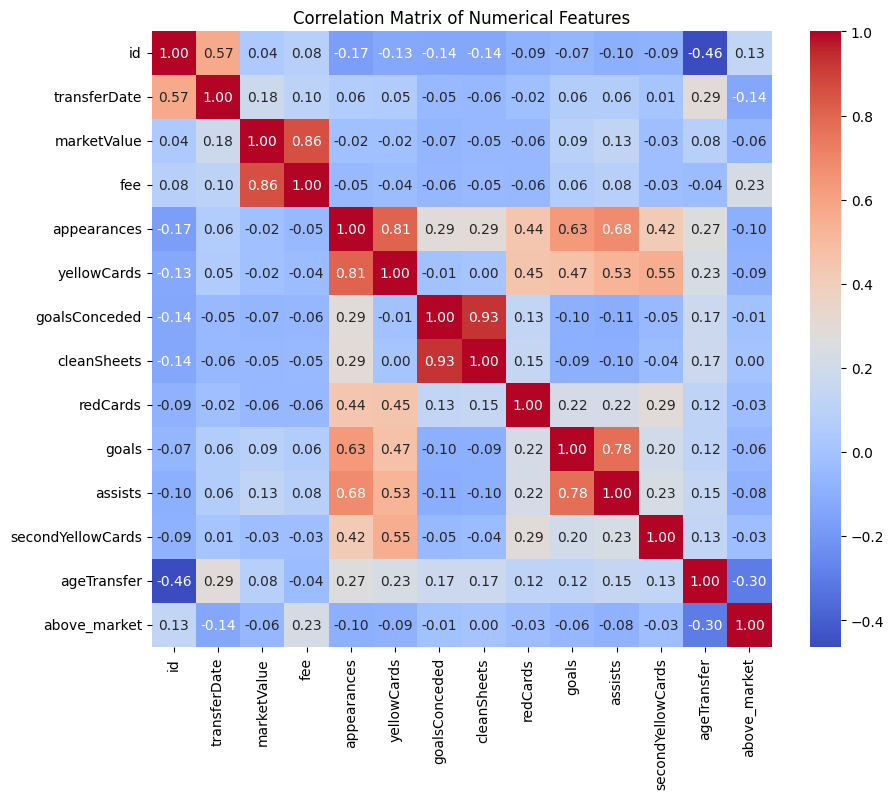

In [5]:
numerical_data = df.select_dtypes(include=['int64'])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Ze względu na to, że marketValue piłkarzy jest zmienną, która duże znaczenie z punktu widzenia dalszej analizy warto pogrupować na podstawie niej zawodników na 4 klastry według ich wartości. Zostanie użyta do tego metoda K-Means, algorytm grupowania danych, który dzieli zestaw obserwacji na określoną liczbę klastrów k, minimalizując sumę kwadratów odległości między obserwacjami a środkami ich klastrów. Wyniki zaprezentowano na poniszym histogramie.

/var/folders/lg/dqrfsgd11p1bnm82y9g576380000gn/T/ipykernel_60874/4151270415.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='cluster', discrete=True, palette='viridis')


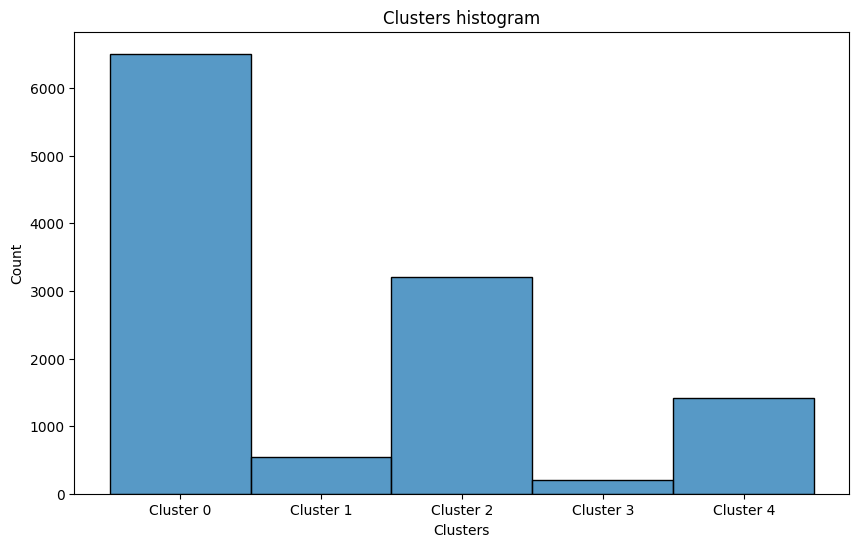

In [6]:
X=df[['marketValue']]
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
df['cluster']=kmeans.labels_

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cluster', discrete=True, palette='viridis')
plt.title("Clusters histogram")
plt.xlabel("Clusters")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.show()

Dla zbadania reszty danych stworzono poniższe wykresy, które prezentują liczność występowania kategorii: 'Competitions', 'position' i 'foot'  w próbce danych.


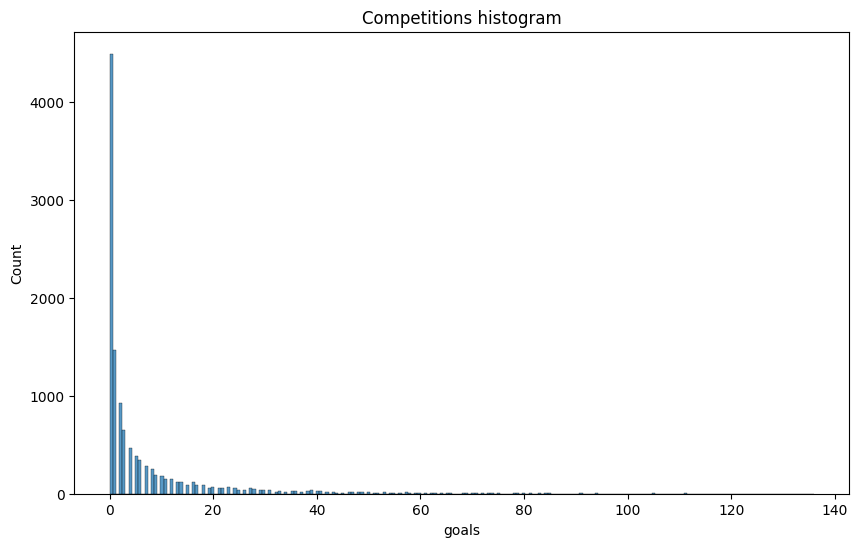

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data= df, x=df['goals'])
plt.title (f"Competitions histogram")
plt.show()

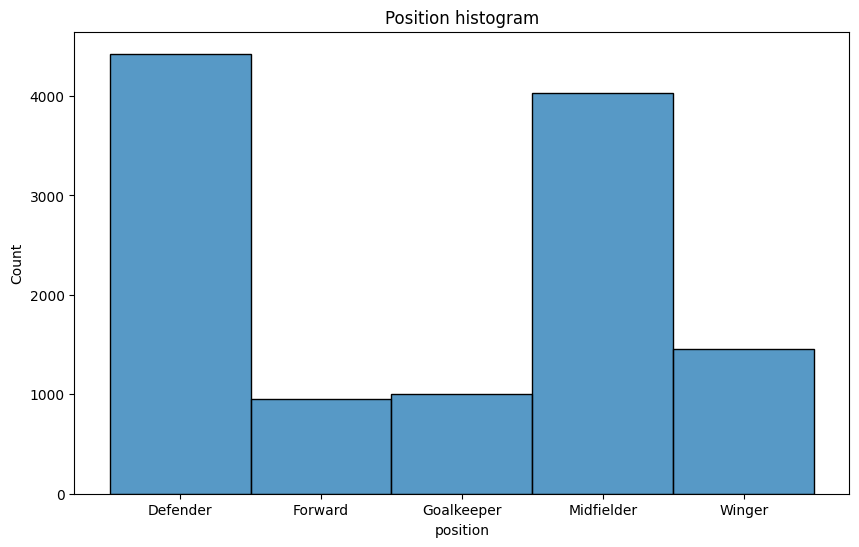

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data= df, x=df['position'])
plt.title (f"Position histogram")
plt.show()

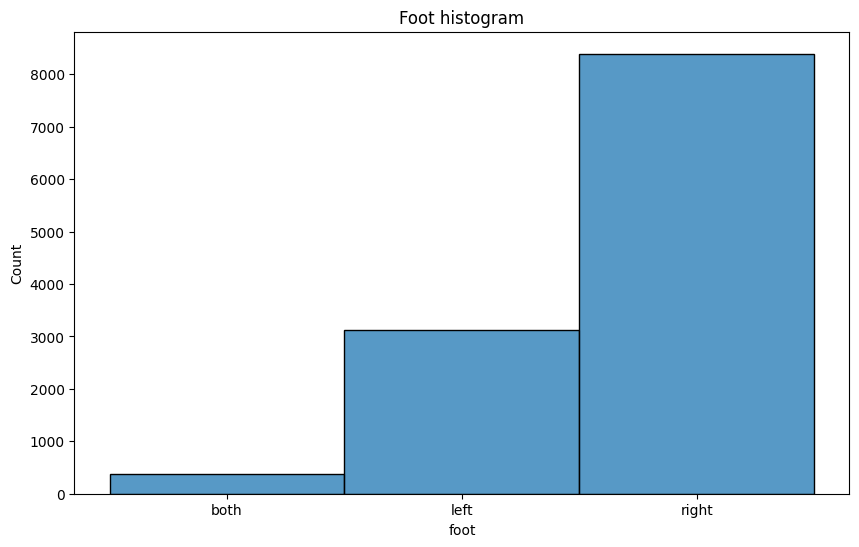

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data= df, x=df['foot'])
plt.title (f"Foot histogram")
plt.show()

## 3. Modelowanie


Do sprawdzenia, którzy piłkarze zostaną sprzedani powyżej ceny rynkowej zostały użyte modele, które pozwalają na łatwe przewidywanie kategorii, czyli regresja logistyczna i lasy losowe. W pierwszej kolejności, dane zostały podzielone na dwie próbki: zbiór treningowy i zbiór testowy.


In [10]:
X_train, X_test, y_train, y_test = dmf.splitting_datasets_class(df)
X_train= dmf.scalling_datasets(X_train)
X_test= dmf.scalling_datasets(X_test)

W następnej kolejności należy przeprowadzić modelowanie. Aby sprawdzić jakość obu modeli posłużono się accuracy (dokładność modelu, tzn. ile przewidywań było poprawnych) i recall (czułość, którą definiuje się, jako zdolność modelu do przewidywania wartości prawdziwie pozytywnych). W świetle celu raportu, metryki te pozwolą na zidentyfikowanie piłkarzy, którzy przedstawiają wyższą wartość, niż ich rynkowa wycena. W obu modelach zmienną objaśnianą będzie ‘above_market’, który definiuje, czy dany piłkarz został sprzedany powyżej, czy poniżej (lub za ceną równą) wartości rynkowej.

#### Model regresji logistycznej

In [11]:
log_reg= models.logistic_regression(X_train, X_test, y_train, y_test)

Czułość modelu 66.0%; Dokładność modelu 63.89%
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      1800
           1       0.63      0.66      0.64      1764

    accuracy                           0.64      3564
   macro avg       0.64      0.64      0.64      3564
weighted avg       0.64      0.64      0.64      3564



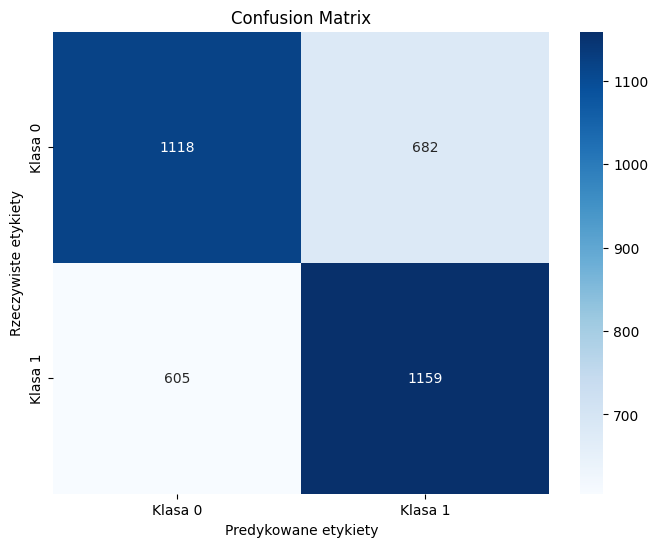

In [12]:
models.conf_matrix (y_test, log_reg)

#### Model Lasu Losowego

In [13]:
rf_class = models.random_forrest_class(X_train, X_test, y_train, y_test)

Czułość modelu 80.0%; Dokładność modelu 79.35%
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1800
           1       0.79      0.80      0.79      1764

    accuracy                           0.79      3564
   macro avg       0.79      0.79      0.79      3564
weighted avg       0.79      0.79      0.79      3564



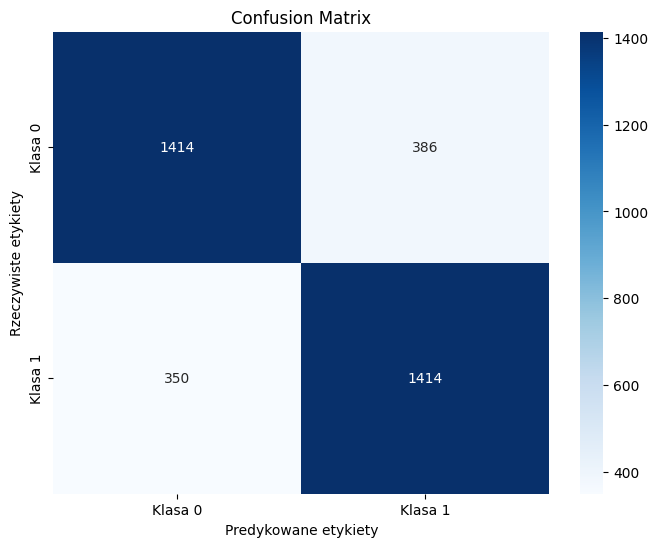

In [14]:
models.conf_matrix (y_test, rf_class)

#### Ocena modeli

Już na pierwszy rzut oka można zauważyć, że model lasów losowych znacznie lepiej poradził sobie ze stawianym przed nim zadaniem. Jego czułość wyniosła 79%, a dokładność 80%. W przypadku regresji logistycznej wyniki te są znacznie gorsze I odpowiednio wynoszą 66% I 63.89%. W przypadku wyceny zawodników może przełożyć się to na konkretne utracone korzyści przez klub i niedostrzeżenie szansy sprzedaży zawodnika z zyskiem, dlatego wybranie modelu lasu losowego będzie znacznie podnosiło pewność, że wytypujemy piłkarza, który przyniesie nam konkretny przychód ze swojej sprzedaży. Jak


## 4. Bibliografia

1. https://en.wikipedia.org/wiki/List_of_most_expensive_association_football_transfers (dostęp: 17.04.2024, godz. 12:40)
2. https://www.transfermarkt.pl/transfers/transfertagedetail/statistik/top/land_id_zu/0/land_id_ab/0/leihe//datum/2024-01-01 (dostęp: 17.04.2024, godz. 12:40)
3. Bruce A., Bruce P., Gedeck P., <i> Statystyka praktyczna w data science, wyd.2, 2021 </i>

1. Wstęp
Cel badania: Wyjaśnij, co dokładnie chcesz osiągnąć za pomocą swojego modelu przewidywania i dlaczego jest to istotne.
Tło badania: Krótkie wprowadzenie do tematu, w tym kontekst dotyczący piłki nożnej i wartości piłkarzy.
Pytania badawcze: Określ pytania, na które zamierzasz odpowiedzieć za pomocą swojego modelu przewidywania.
2. Przegląd literatury
Przegląd istniejących badań: Omówienie dotychczasowych badań i metod używanych do przewidywania wartości piłkarzy oraz jakie były ich wyniki.
3. Dane
Opis zbioru danych: Opisz skąd pochodzą Twoje dane, jakie zawierają zmienne, ile jest obserwacji itp.
Wstępne przetwarzanie danych: Opisz jakie kroki podjąłeś aby przygotować dane do analizy (czyszczenie danych, transformacja zmiennych, itd.).
4. Metodologia
Wybór metod: Opisz jakie techniki statystyczne lub algorytmy uczenia maszynowego planujesz użyć do budowy modelu przewidywania wartości piłkarzy.
Walidacja modelu: Opisz metody, które zastosujesz do oceny skuteczności modelu (np. walidacja krzyżowa, metryki oceny jak MAE, RMSE).
5. Wyniki
Prezentacja wyników modelowania: Przedstaw wyniki modeli, które zbudowałeś, włącznie z interpretacją współczynników modelu (jeśli to modele regresyjne).
Analiza wyników: Omów, które zmienne miały największy wpływ na wartość piłkarzy i jak model radzi sobie z przewidywaniami.
6. Dyskusja
Interpretacja wyników: Jak wyniki wpisują się w kontekst istniejących badań? Czy są jakieś niespodzianki lub oczekiwane wyniki?
Ograniczenia badania: Jakie są ograniczenia Twojego badania i modelu? Co mogłoby być zrobione inaczej?
7. Wnioski
Podsumowanie głównych odkryć: Krótkie streszczenie najważniejszych wyników i odpowiedzi na pytania badawcze.
Praktyczne zastosowania: Jak wyniki mogą być użyte w praktyce, np. przez kluby piłkarskie, agencje reprezentujące piłkarzy, media sportowe, itp.
Kierunki przyszłych badań: Sugestie dotyczące tego, jakie inne aspekty wartości piłkarzy mogłyby być badane w przyszłości.
8. Bibliografia
Źródła: Lista wszystkich cytowanych źródeł naukowych, raportów i innych materiałów, które wykorzystałeś w swojej pracy.
9. Załączniki / Dodatki
Kod źródłowy: Załącz kod użyty do analizy danych i budowy modelu.
Dodatkowe wykresy i tabelki: Materiały, które wspierają Twoją analizę, ale nie zostały włączone głównie do tekstu.

In [ ]:
ref_data= pd.read_csv('Data/Input/Other/clubs_md.csv')

In [ ]:
ref_data

,Unnamed: 0,id,name,Competitions
0,0,281,Manchester City,GB1
1,1,11,Arsenal FC,GB1
2,2,631,Chelsea FC,GB1
3,3,985,Manchester United,GB1
4,4,31,Liverpool FC,GB1
...,...,...,...,...
106,18,1531,Elche CF,ES1
107,19,2687,Cádiz CF,ES1
108,20,1108,Deportivo Alavés,ES1
109,21,472,UD Las Palmas,ES1


In [ ]:
df.fillna('Other')

TypeError: Cannot setitem on a Categorical with a new category (Other), set the categories first